In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter("ignore", category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    warnings.simplefilter('ignore', UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_1samp, spearmanr
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.spatial.distance import pdist
# system module
from os import mkdir, getcwd
import subprocess
import re,glob, sys, copy, time
from os.path import isdir,isfile, join, exists
##stats modules
## fmri modules
import nibabel as nb
from nltools.data import Brain_Data, Adjacency
from nltools.stats import isc, isfc, isps, fdr, threshold, matrix_permutation
from nltools.mask import expand_mask, roi_to_brain
from nltools.data import Design_Matrix

from bids import BIDSLayout, BIDSValidator
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel, non_parametric_inference
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_roi, plot_matrix, view_img, view_img_on_surf
from nilearn.image import mean_img, smooth_img
from nilearn import maskers
from nilearn.masking import apply_mask
from nilearn.reporting import get_clusters_table
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds

rng = 123
base_dir = "/home/.admin/chingfc/BART"

In [4]:
def sort_file(file):
    
    subj_id = re.findall("sub-(\d+)", file)[0]
    return int(subj_id)

def get_subjid(path:str):
    
    return re.findall(r'sub-(\d+)_task', subj)[0]

def get_expdata(subj:str):
    
    path = join(base_dir, "behavior_data","data_with_trial_reward/", f"subject_{subj}_task_bart.csv")
    return pd.read_csv(path)

def timeseries_means(data):
    
    means = []
    if not isinstance(data, nb.nifti1.Nifti1Image):
        raise("this data is not nifti image!")
    
    data = data.get_fdata()
    for i in range(data.shape[-1]):
        means.append(data[:,:,:, i].ravel().mean())
    return np.array(means)

def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

def lower_mtx(mtx):
    
    return mtx[np.tril_indices_from(mtx, k=-1)]
    
def permutation(modelDist, brainDist_vec, n_permute):
    corr = spearmanr(modelDist,brainDist_vec)[0]
    perm = []
    for p in range(n_permute):
        perm.append(spearmanr(np.random.permutation(modelDist),brainDist_vec)[0])
    if corr>=0:
        perm_p = np.mean(perm>=corr)
    else:
        perm_p = np.mean(perm<=corr)
    pval = perm_p
    return corr, pval

In [ ]:
layout = BIDSLayout(join(base_dir,"fmri_data"), derivatives=True)
layout

In [6]:
subjects = np.loadtxt(join(base_dir, 'code', 'subject.csv'), skiprows=1, dtype=str)

In [ ]:
model_data = pd.read_csv('model_ewmv.csv', index_col=0)
model_data.index = model_data.index.map(lambda x: f'{x:03d}')
model_data = model_data.loc[subjects]

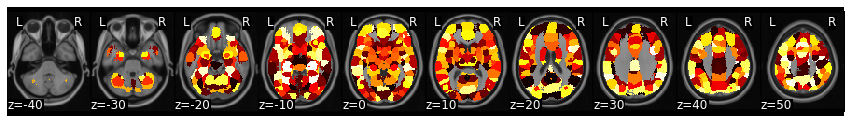

In [24]:
roi_mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_2.nii.gz')
mask_x = expand_mask(roi_mask)
roi_mask.plot()
masker = maskers.NiftiLabelsMasker(
    labels_img=roi_mask.to_nifti(), 
    standardize=False, 
    low_pass=None,
    high_pass=None,
)

In [ ]:
conditions = ['explosion', 'intact',  'inflation']
for cond in conditions:
    exists(join(base_dir, '200parcels', cond)) or mkdir(join(base_dir, '200parcels', cond));
    for parcel in range(200):
        print(f'======condition {cond}, parcel {parcel}===========')
        parcel_data = {}
        for subj in subjects:
            brain_data = Brain_Data(join(base_dir, 'zmap', f'sub-{subj}_bart-{cond}_zmap.nii.gz'))
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', UserWarning)
                parcel_data[subj]= brain_data.apply_mask(mask_x[parcel]).data

        parcel_data = pd.DataFrame.from_dict(parcel_data)
        parcel_data.T.to_csv(join(base_dir, '200parcels', cond, f'task-bart_parcel-{parcel}_{cond}.csv'))